# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Файл _labels.csv_

In [1]:
# Импорт библиотек
import pandas as pd
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Чтение файлов с данными
pth1 = '/datasets/faces/labels.csv'
pth1_local = 'D:/DS' + pth1
    
if os.path.exists(pth1):
    labels = pd.read_csv(pth1) 
    
elif os.path.exists(pth1_local):
    labels = pd.read_csv(pth1_local)

else:
    print('Файлы не найдены')

In [3]:
# Размер выборки
labels.shape

(7591, 2)

In [4]:
#Выводим первые 5 строчек датафрейма на экран.
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
#Выводим основную информацию о датафрейме
labels.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
# Количество дубликатов
labels.duplicated().sum()

0

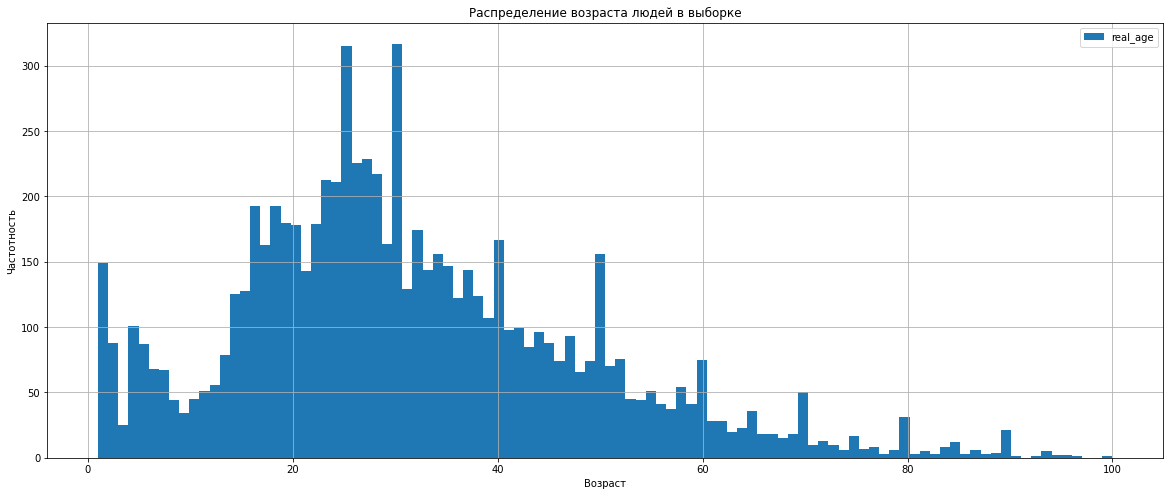

In [7]:
# Построим график распределения возраста в выборке
labels.plot(
        title = 'Распределение возраста людей в выборке',
        kind='hist', 
        bins=100, 
        grid=True, 
        legend=True,
        figsize=(20, 8),
    ).set(xlabel='Возраст', ylabel='Частотность');

**Вывод:**

В выбороке 7591 записей и 2 столбца. Пропусков и дубликатов нет.

Наибольшее количество фотографий приходится на возраст 17-40 лет. После 90 лет фотографий мало.

### Открываем фотографии

In [8]:
# Исследуем фотографии
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=241607)

Found 7591 validated image filenames.


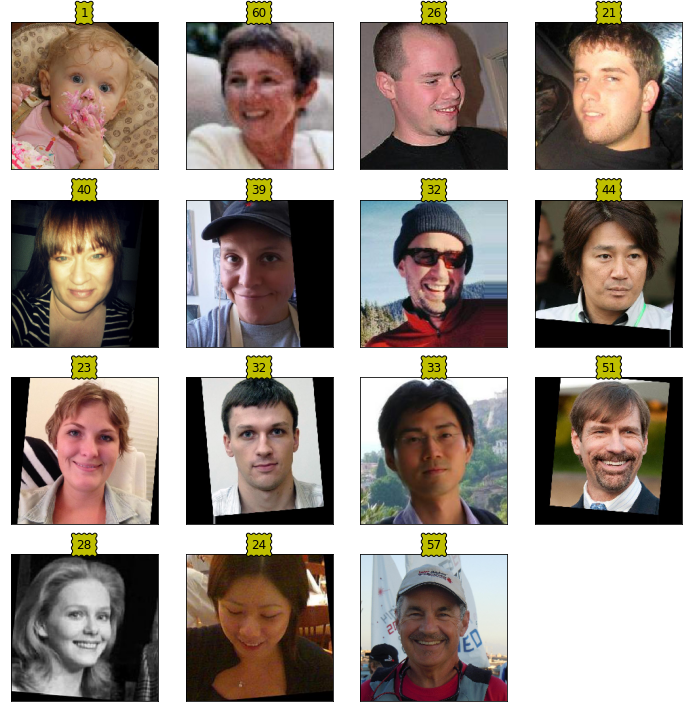

In [9]:
# Выведем 15 фото
features, target = next(train_gen_flow)

bbox_properties=dict(
    boxstyle="Roundtooth, pad=0.5", 
    ec="k",
    fc="y",
    ls="-",
    lw=1   
)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i], bbox=bbox_properties)


**Вывод:**

Выведено 15 фотографий из 7591. На фотографиях есть предметы, которые закрывают лицо и голову. Еда, головной убор, очки, например. Также есть повернутые фотографии, смазанные фотографии, с посторонними людьми и предметами. Это создаст сложность для оценки возраста.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

### Код обучения модели

In [10]:
# Импорт библиотек
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Извлечение обучающих данных
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=241607)

    return train_gen_flow

# Извлечение тестовых данных
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=241607)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=11,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

### Результат вывода на экран

In [ ]:
# Train for 178 steps, validate for 60 steps
Epoch 1/11
2023-08-18 12:05:23.558858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-18 12:05:23.962111: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 71s - loss: 238.3644 - mae: 11.0322 - val_loss: 930.7789 - val_mae: 25.7340
Epoch 2/11
178/178 - 55s - loss: 75.3063 - mae: 6.5394 - val_loss: 912.8262 - val_mae: 25.4324
Epoch 3/11
178/178 - 54s - loss: 47.9628 - mae: 5.2547 - val_loss: 374.1822 - val_mae: 14.5254
Epoch 4/11
178/178 - 53s - loss: 32.5902 - mae: 4.3560 - val_loss: 163.7427 - val_mae: 10.2172
Epoch 5/11
178/178 - 51s - loss: 26.4676 - mae: 3.9269 - val_loss: 74.2851 - val_mae: 6.5557
Epoch 6/11
178/178 - 50s - loss: 21.5840 - mae: 3.5625 - val_loss: 92.0179 - val_mae: 7.1837
Epoch 7/11
178/178 - 47s - loss: 18.5314 - mae: 3.2725 - val_loss: 62.4292 - val_mae: 5.8701
Epoch 8/11
178/178 - 47s - loss: 14.6129 - mae: 2.9299 - val_loss: 63.6138 - val_mae: 6.0780
Epoch 9/11
178/178 - 46s - loss: 13.5691 - mae: 2.7905 - val_loss: 73.5127 - val_mae: 6.5900
Epoch 10/11
178/178 - 38s - loss: 11.7816 - mae: 2.6210 - val_loss: 66.3707 - val_mae: 6.1999
Epoch 11/11
178/178 - 38s - loss: 9.8876 - mae: 2.3715 - val_loss: 63.2491 - val_mae: 5.9288
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 63.2491 - mae: 5.9288
Test MAE: 5.9288

## Анализ обученной модели

Модель обучалась на 11 эпохах.

На модели метрика МАЕ уменьшилась от 11.0322 до 2.3715. На тестовой выборке МАЕ минимальный результат получила 5.9288.

Поставленная задача решена. MAE<8. Качество модели соответствует заданию.